This notebook aims to cluster the GLD360 lightning stroke data into flash data.

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

## Read daily GLD360 density data

In [2]:
df = pd.read_csv('../data/gld360/Arctic Lightning August 10-13.csv')
df['time'] = pd.to_datetime(df['time'])

# convert datetime into seconds
df['delta'] = (df['time']-df['time'].min()).dt.total_seconds()

## Cluster by time (500 ms)

In [3]:
db = DBSCAN(eps=0.5, min_samples=1, algorithm='ball_tree').fit(df['delta'].values.reshape(-1, 1))
cluster_labels = db.labels_
# save to new column named "time_label"
df['time_label'] = cluster_labels

## Cluster by location (20 km)

In [4]:
def db_loc(df):
    coords = df[['latitude', 'longitude']].values
    kms_per_radian = 6371.0088

    # search for 20km around each lightning dots
    epsilon = 20/kms_per_radian

    db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree').fit(np.radians(coords))
    cluster_labels = db.labels_
    return pd.Series(cluster_labels)

# save to new column named "loc_label"
df['loc_label'] = df.groupby('time_label').apply(lambda row: db_loc(row)).reset_index(drop=True)

In [5]:
# group by two condition
comb_grp = df.groupby(['time_label','loc_label'])

# use the first datetime of stroke as the flash time
df_flash = comb_grp[['time','longitude','latitude']].nth(0).reset_index(drop=True)

# if any stroke is CG, the flash is CG
cloud_flag = comb_grp['cloud'].all().reset_index(drop=True).rename('cloud')
df_flash['cloud'] = cloud_flag

In [6]:
# # save the data
# df_flash.to_csv('arctic_flash_test.csv', index=False)

## Case

In [7]:
df[df['time_label']==848]

,time,longitude,latitude,signalStrengthKA,cloud,delta,time_label,loc_label
1600,2019-08-12 13:22:35.924000+00:00,90.0627,78.8102,-36.4,False,219810.582,848,0
1601,2019-08-12 13:22:35.954000+00:00,89.9164,78.7724,-8.1,False,219810.612,848,0
1602,2019-08-12 13:22:35.993000+00:00,89.7954,78.8150,-17.0,False,219810.651,848,0
1603,2019-08-12 13:22:36.020000+00:00,89.9286,78.7988,-27.5,False,219810.678,848,0
1604,2019-08-12 13:22:36.047000+00:00,89.8578,78.7879,-14.4,False,219810.705,848,0
1605,2019-08-12 13:22:36.093000+00:00,89.1329,78.7320,22.5,False,219810.751,848,1
1606,2019-08-12 13:22:36.107000+00:00,89.8719,78.7802,5.5,True,219810.765,848,0


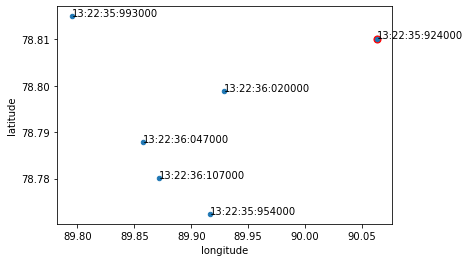

In [8]:
fig, ax = plt.subplots()

test = df[(df['time_label']==848)&(df['loc_label']==0)]

# plot the flash location
df_flash.loc[df_flash['time']==test.iloc[0]['time']].plot.scatter(ax=ax, x='longitude', y='latitude', c='r', s=50)

# plot the stroke location and time
test.plot.scatter(x='longitude', y='latitude', ax=ax)
for i, point in test.iterrows():
        ax.text(point['longitude'], point['latitude'], point['time'].strftime('%H:%M:%S:%f'))